In [2]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import iefc_2dm as iefc
from wfsc import utils

dm_dir = cgi.data_dir/'dm-acts'

dm1_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm2.fits')

# dm1_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm1.fits')
# dm2_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm2.fits')

In [2]:
cgi.__file__

'/home/u21/kianmilani/src/cgi-phasec-poppy/cgi_phasec_poppy/__init__.py'

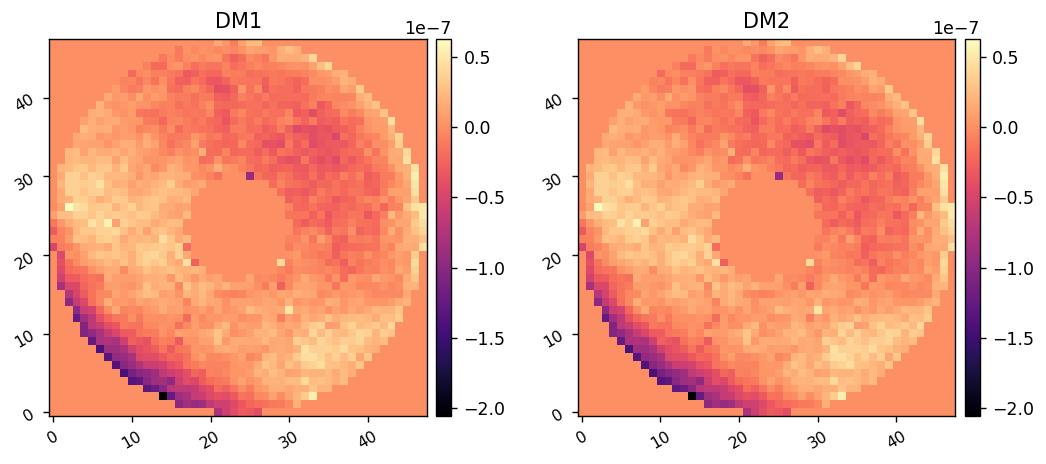

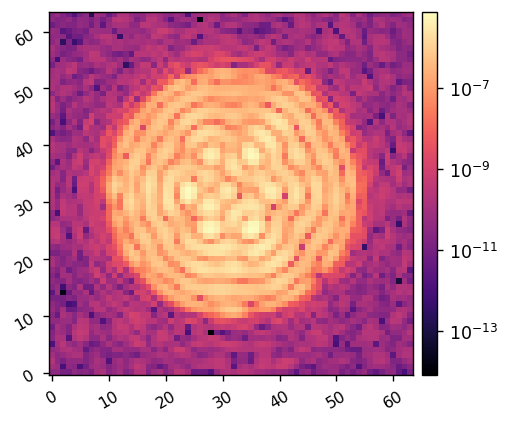

In [3]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
hlc.show_dms()

npsf = hlc.npsf
Nact = hlc.Nact

ref_psf = hlc.snap()

misc.myimshow(ref_psf, lognorm=True)

# Create dark hole ROI to calibrate and control

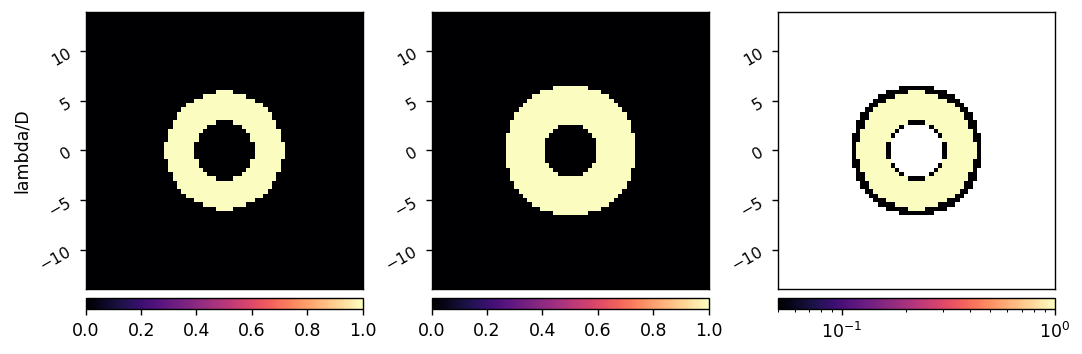

In [4]:
reload(utils)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlc.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 6
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
    'full':True,
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.2,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
    'rotation':rot,
    'full':True,
}
control_mask = utils.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.95
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow3(dh_mask.reshape(npsf,npsf),
               control_mask.reshape(npsf,npsf), 
               weights.reshape(npsf,npsf),
               lognorm3=True,
               pxscl1=hlc.psf_pixelscale_lamD, pxscl2=hlc.psf_pixelscale_lamD, pxscl3=hlc.psf_pixelscale_lamD)

# Create probe and fourier modes

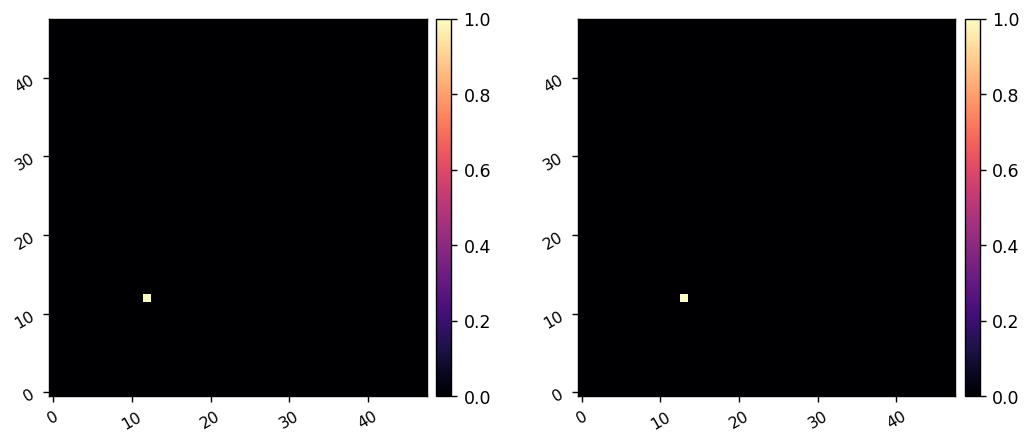

Creating Fourier modes:  (64, 64)
Calibration modes required: 272


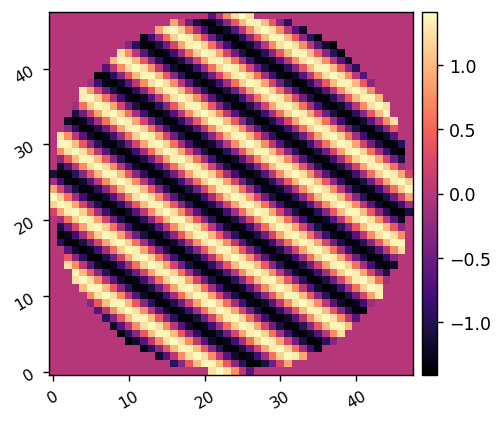

In [7]:
reload(iefc)
probe_modes = iefc.create_probe_poke_modes(Nact, 
                                           xinds=[Nact//4, Nact//4+1],
                                           yinds=[Nact//4, Nact//4], 
                                           display=True)

calibration_modes, fx, fy = iefc.create_fourier_modes(xfp, 
                                                      control_mask.reshape((npsf,npsf)), 
                                                      Nact, 
                                                      circular_mask=False)
calibration_modes[:] *= hlc.dm_mask.flatten()

nmodes = calibration_modes.shape[0]
print('Calibration modes required: {:d}'.format(nmodes))
misc.myimshow(calibration_modes[0].reshape(Nact,Nact))

calibration_amplitude = 0.006 * hlc.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * hlc.wavelength_c.to(u.m).value

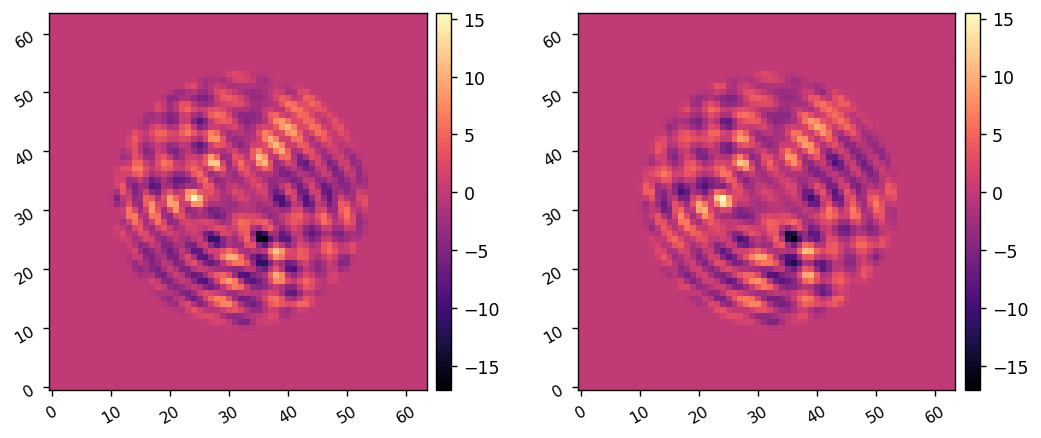

In [8]:
reload(iefc)
hlc.reset_dms()
differential_images, single_images = iefc.take_measurement(hlc, probe_modes, probe_amplitude, 
                                                           return_all=True, display=True)

# Calibrate IEFC (or load in previous calibration data)

In [9]:
reload(iefc)
response_cube, calibration_cube = iefc.calibrate(hlc, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 272 in 5.207s
	Calibrated mode 2 / 272 in 10.273s
	Calibrated mode 3 / 272 in 15.358s
	Calibrated mode 4 / 272 in 20.437s
	Calibrated mode 5 / 272 in 25.512s
	Calibrated mode 6 / 272 in 30.604s
	Calibrated mode 7 / 272 in 35.710s
	Calibrated mode 8 / 272 in 40.801s
	Calibrated mode 9 / 272 in 45.974s
	Calibrated mode 10 / 272 in 51.154s
	Calibrated mode 11 / 272 in 56.229s
	Calibrated mode 12 / 272 in 61.279s
	Calibrated mode 13 / 272 in 66.246s
	Calibrated mode 14 / 272 in 71.217s
	Calibrated mode 15 / 272 in 76.255s
	Calibrated mode 16 / 272 in 81.408s
	Calibrated mode 17 / 272 in 86.567s
	Calibrated mode 18 / 272 in 91.617s
	Calibrated mode 19 / 272 in 96.669s
	Calibrated mode 20 / 272 in 101.758s
	Calibrated mode 21 / 272 in 106.813s
	Calibrated mode 22 / 272 in 111.957s
	Calibrated mode 23 / 272 in 117.039s
	Calibrated mode 24 / 272 in 122.088s
	Calibrated mode 25 / 272 in 127.162s
	Calibrated mode 26 / 272 in 132.228s
	Calibrated mode 27 

	Calibrated mode 214 / 272 in 1091.933s
	Calibrated mode 215 / 272 in 1097.012s
	Calibrated mode 216 / 272 in 1102.099s
	Calibrated mode 217 / 272 in 1107.151s
	Calibrated mode 218 / 272 in 1112.219s
	Calibrated mode 219 / 272 in 1117.401s
	Calibrated mode 220 / 272 in 1122.499s
	Calibrated mode 221 / 272 in 1127.556s
	Calibrated mode 222 / 272 in 1132.634s
	Calibrated mode 223 / 272 in 1137.777s
	Calibrated mode 224 / 272 in 1142.941s
	Calibrated mode 225 / 272 in 1147.988s
	Calibrated mode 226 / 272 in 1153.058s
	Calibrated mode 227 / 272 in 1158.128s
	Calibrated mode 228 / 272 in 1163.221s
	Calibrated mode 229 / 272 in 1168.432s
	Calibrated mode 230 / 272 in 1173.614s
	Calibrated mode 231 / 272 in 1178.791s
	Calibrated mode 232 / 272 in 1183.890s
	Calibrated mode 233 / 272 in 1188.979s
	Calibrated mode 234 / 272 in 1194.088s
	Calibrated mode 235 / 272 in 1199.188s
	Calibrated mode 236 / 272 in 1204.279s
	Calibrated mode 237 / 272 in 1209.362s
	Calibrated mode 238 / 272 in 1214.521s


In [11]:
fname = 'hlc_2dm_annular_36'
iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

In [13]:
import os
os.mkdir(str(iefc_dir/'test_dir'))

In [12]:
misc.save_pickle(iefc_dir/'response-data'/fname, response_cube)
misc.save_pickle(iefc_dir/'calibration-data'/fname, calibration_cube)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_2dm_annular_36
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/hlc_2dm_annular_36


In [9]:
response_cube = misc.load_pickle(iefc_dir/'response-data'/fname)
calibration_cube = misc.load_pickle(iefc_dir/'calibration-data'/fname)

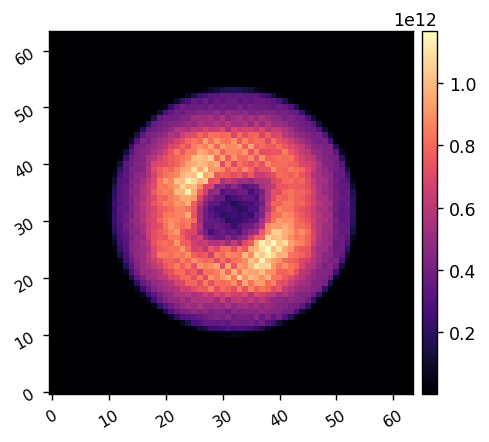

In [10]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64))

# Create control matrix

In [14]:
reload(iefc)
# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix = iefc.construct_control_matrix(response_cube, 
                                               weights.flatten(), 
                                               rcond1=1e-2,
                                               rcond2=1e-2,
                                               nprobes=probe_modes.shape[0], pca_modes=None)

Using Weighted Least Squares 


# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 10


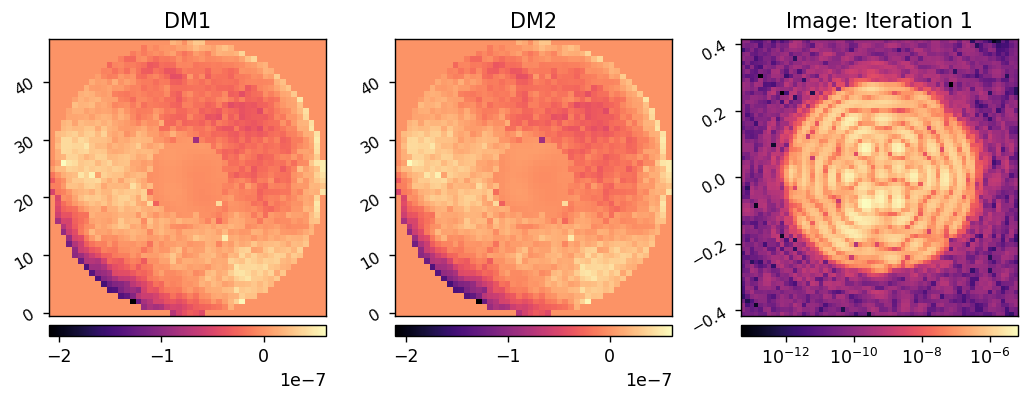

	Closed-loop iteration 2 / 10


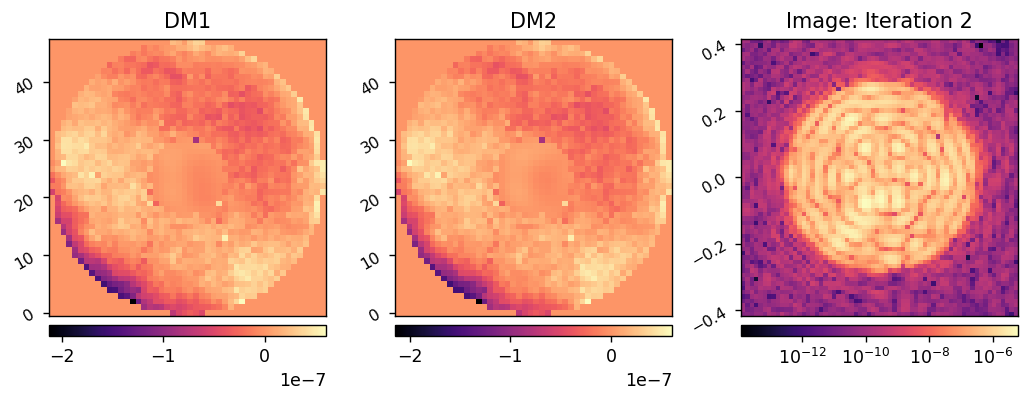

	Closed-loop iteration 3 / 10


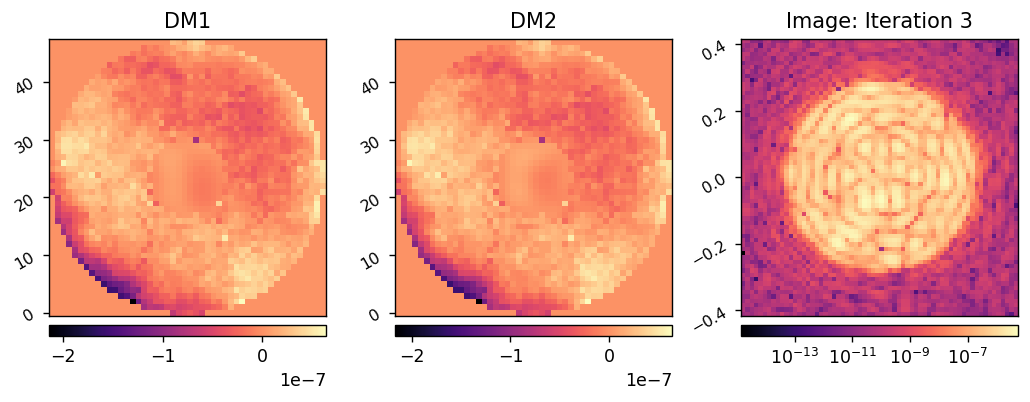

	Closed-loop iteration 4 / 10


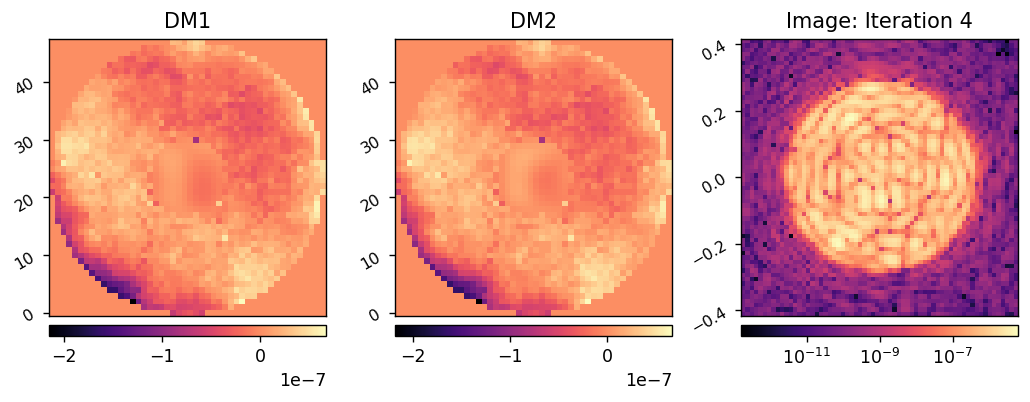

	Closed-loop iteration 5 / 10


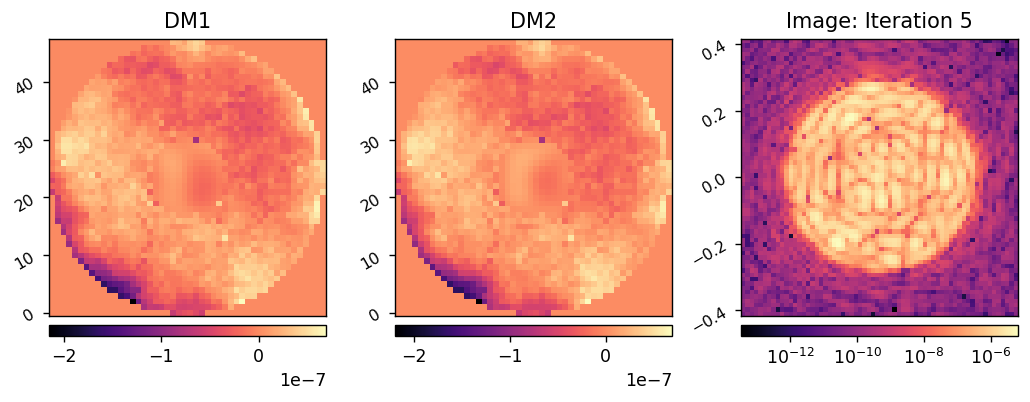

	Closed-loop iteration 6 / 10


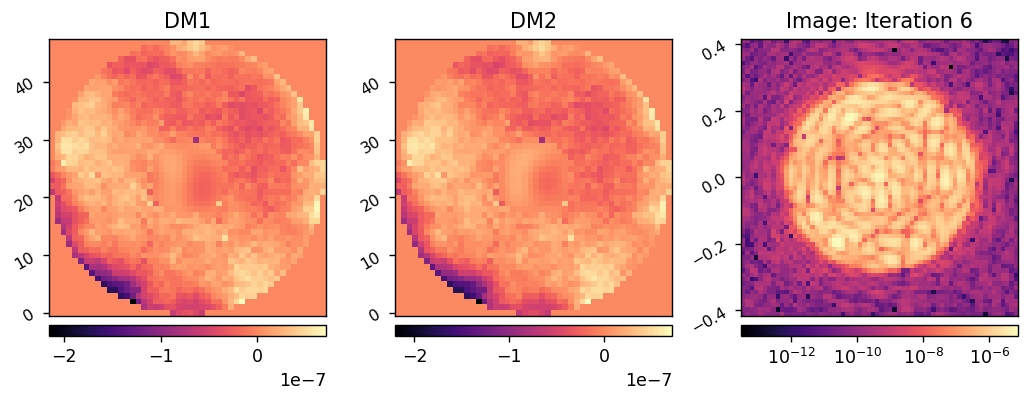

	Closed-loop iteration 7 / 10


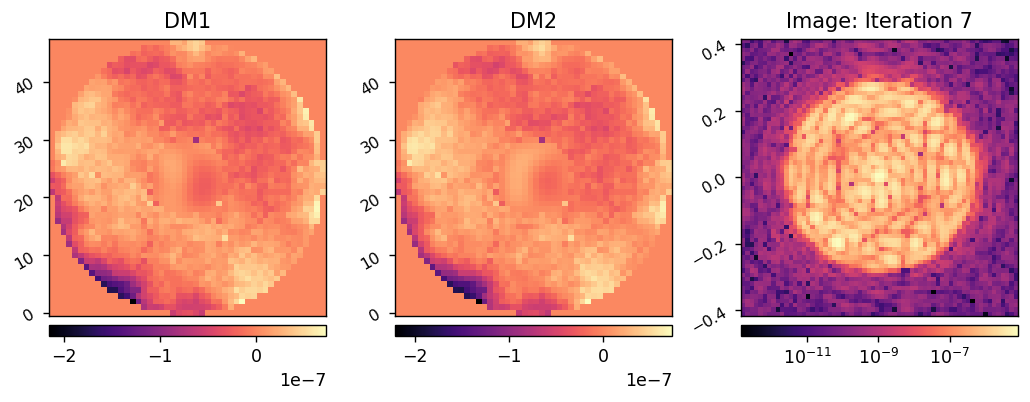

	Closed-loop iteration 8 / 10


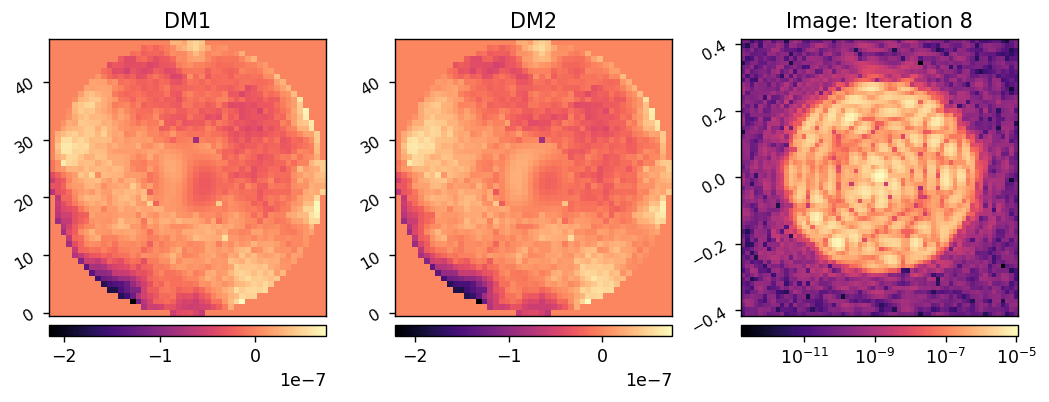

	Closed-loop iteration 9 / 10


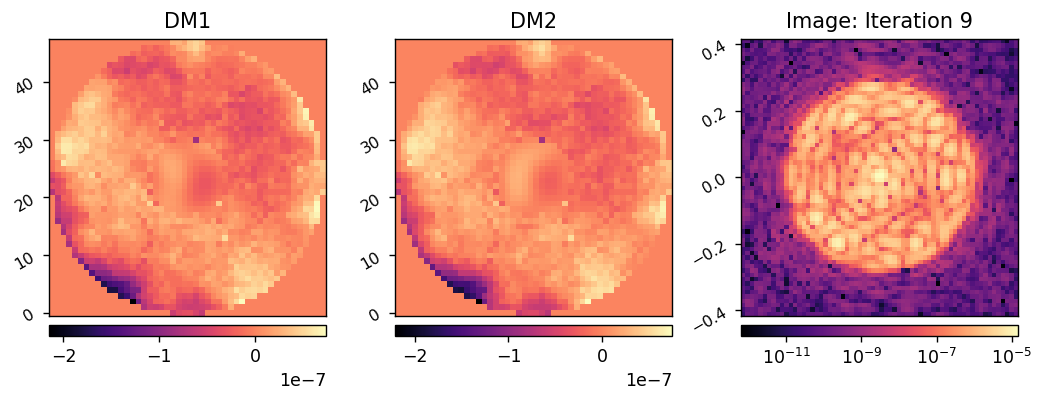

	Closed-loop iteration 10 / 10


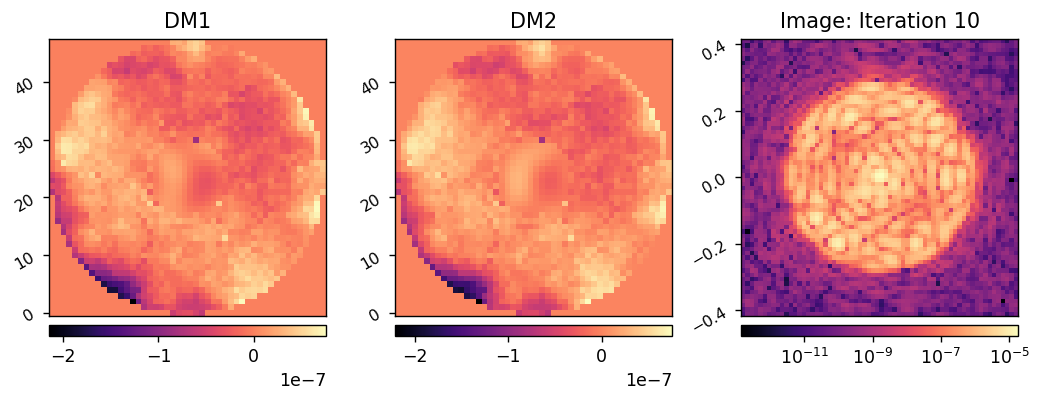

I-EFC loop completed in 19.573s.


In [15]:
reload(iefc)

hlc.reset_dms()

images, dm1_commands, dm2_commands = iefc.run(hlc, 
                                              control_matrix, 
                                              probe_modes, 
                                              probe_amplitude, 
                                              calibration_modes, 
                                              weights, 
                                              num_iterations=10, 
                                              gain=-0.5, leakage=0.0,
                                              display=True)

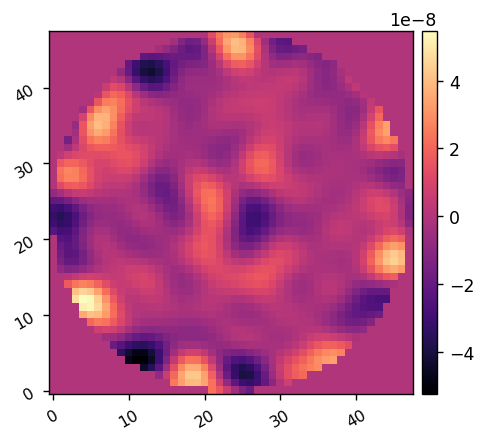

In [19]:
dm1 = hlc.get_dm1()

misc.myimshow(dm1-dm1_flat)

In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
